In [1]:
GLOBAL_SEED = 42
import numpy as np
np.random.seed(GLOBAL_SEED)
import itertools
import functools
import operator
import matplotlib.pyplot as plt
from matplotlib import pylab
import torch
from m_layer import MLayer
DEVICE = 'cpu'
from utils import NpDataset
from torch.utils.data import DataLoader
from ignite.engine import Engine
from ignite.metrics import Accuracy, Loss, Average
from ignite.engine import Events
from IPython.display import clear_output
import pandas as pd
import seaborn as sns
sns.set()

`Daily minimum temperatures in Melbourne` dataset preparation (dataset is available on [kaggle](https://www.kaggle.com/paulbrabban/daily-minimum-temperatures-in-melbourne))

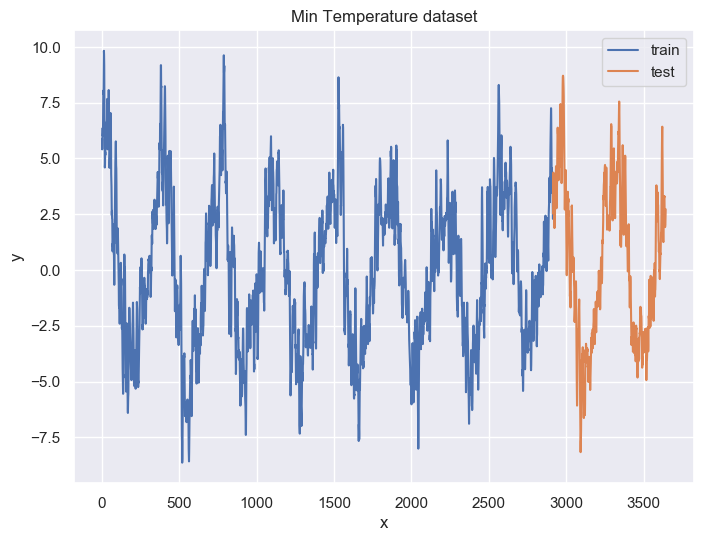

In [2]:
data = pd.read_csv('daily-minimum-temperatures.csv')
dates = data['Date']
temperatures = data['Temp'].astype(float)
y = list(np.convolve(temperatures - np.mean(temperatures), np.full(7, 1 / 7),
                    mode='valid'))

num_train = 8 * len(y) // 10
num_test = len(y) - num_train
x_all = np.arange(len(y)).tolist()
x_train = x_all[:num_train]
y_train = y[:num_train]
x_test = x_all[num_train:]
y_test = y[num_train:]

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(x_train, y_train, label='train')
plt.plot(x_test, y_test, label='test')
plt.title('Min Temperature dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

train_ds = NpDataset((x_train, y_train))
test_ds = NpDataset((x_test, y_test))
all_ds = NpDataset((x_all, y))

In [3]:
from models import PeriodicMLayer
from matrix_exponentials import SecondGreatLimitExpm

Let's launch the NN with `MLayer` training with specified parameters, copypasted from the original paper

In [16]:
PERIODIC_EPOCHS = 100
PERIODIC_BATCH_SIZE = 128
PERIODIC_LR = 0.00001
PERIODIC_DIM_MATRIX = 10
PERIODIC_INIT_SCALE = 0.01
PERIODIC_DIAG_INIT = 10.
PERIODIC_SEED = 123
PERIODIC_LAYER_SIZE = 2

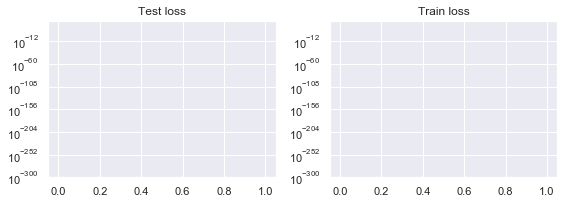

In [17]:
torch.manual_seed(42)
net = PeriodicMLayer(PERIODIC_LAYER_SIZE, PERIODIC_DIM_MATRIX, PERIODIC_INIT_SCALE, PERIODIC_DIAG_INIT, SecondGreatLimitExpm(6), device=DEVICE)
optimizer = torch.optim.RMSprop(net.parameters(), lr=PERIODIC_LR)
train_dl = DataLoader(train_ds, batch_size=PERIODIC_BATCH_SIZE, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=PERIODIC_BATCH_SIZE, shuffle=False, drop_last=False)

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.utils import convert_tensor
import torch.nn as nn

train_loss = []
test_loss = []

criterion = nn.MSELoss()

def prepare_batch(batch, device = None, non_blocking = False):
    x, y = batch
    x = x.float().view(-1, 1)
    y = y.float()
    return (
        convert_tensor(x, device=device, non_blocking=non_blocking),
        convert_tensor(y, device=device, non_blocking=non_blocking),
    )

trainer = create_supervised_trainer(net, optimizer, criterion, prepare_batch=prepare_batch)

val_metrics = {
    "nll": Loss(criterion)
}
evaluator = create_supervised_evaluator(net, metrics=val_metrics, prepare_batch=prepare_batch)

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dl)
    metrics = evaluator.state.metrics
    train_loss.append(metrics['nll'])
    evaluator.run(test_dl)
    metrics = evaluator.state.metrics
    test_loss.append(metrics['nll'])
    if (trainer.state.epoch) % 10 == 0:
        clear_output(wait=True)
        _, (ax1 ,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 3))
        ax1.semilogy(test_loss)
        ax1.set_title('Test loss')
        ax2.semilogy(train_loss)
        ax2.set_title('Train loss')
        plt.tight_layout()
        plt.show()


_ = trainer.run(train_dl, max_epochs=PERIODIC_EPOCHS)

Actually, the algorithm diverge starting from the first iteration.

We tried to launch the NN training using other parameters

In [24]:
PERIODIC_EPOCHS = 100
PERIODIC_BATCH_SIZE = 128
PERIODIC_LR = 0.00001
PERIODIC_DIM_MATRIX = 10
PERIODIC_INIT_SCALE = 0.001
PERIODIC_DIAG_INIT = 0.01
PERIODIC_SEED = 123
PERIODIC_LAYER_SIZE = 2

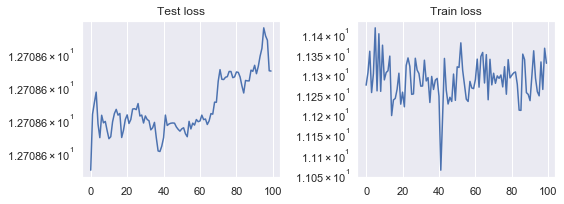

In [25]:
torch.manual_seed(42)
net = PeriodicMLayer(PERIODIC_LAYER_SIZE, PERIODIC_DIM_MATRIX, PERIODIC_INIT_SCALE, PERIODIC_DIAG_INIT, SecondGreatLimitExpm(6), device=DEVICE)
optimizer = torch.optim.RMSprop(net.parameters(), lr=PERIODIC_LR)
train_dl = DataLoader(train_ds, batch_size=PERIODIC_BATCH_SIZE, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=PERIODIC_BATCH_SIZE, shuffle=False, drop_last=False)

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.utils import convert_tensor
import torch.nn as nn

train_loss = []
test_loss = []

criterion = nn.MSELoss()

def prepare_batch(batch, device = None, non_blocking = False):
    x, y = batch
    x = x.float().view(-1, 1)
    y = y.float()
    return (
        convert_tensor(x, device=device, non_blocking=non_blocking),
        convert_tensor(y, device=device, non_blocking=non_blocking),
    )

trainer = create_supervised_trainer(net, optimizer, criterion, prepare_batch=prepare_batch)

val_metrics = {
    "nll": Loss(criterion)
}
evaluator = create_supervised_evaluator(net, metrics=val_metrics, prepare_batch=prepare_batch)

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dl)
    metrics = evaluator.state.metrics
    train_loss.append(metrics['nll'])
    evaluator.run(test_dl)
    metrics = evaluator.state.metrics
    test_loss.append(metrics['nll'])
    if (trainer.state.epoch) % 10 == 0:
        clear_output(wait=True)
        _, (ax1 ,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 3))
        ax1.semilogy(test_loss)
        ax1.set_title('Test loss')
        ax2.semilogy(train_loss)
        ax2.set_title('Train loss')
        plt.tight_layout()
        plt.show()


_ = trainer.run(train_dl, max_epochs=PERIODIC_EPOCHS)

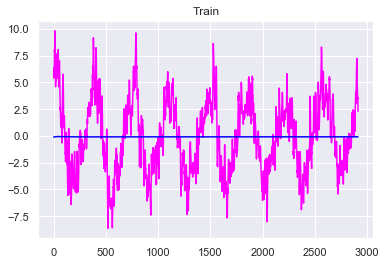

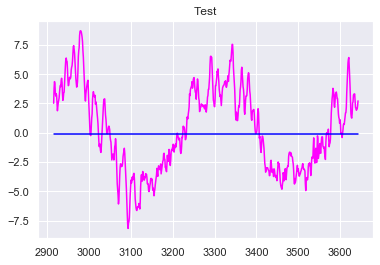

In [26]:
def visualize_ds(net, ds, name):
    tr_dl = DataLoader(ds, batch_size=len(ds))
    x_tr, y_tr = prepare_batch(next(iter(tr_dl)))
    y_tr_pred = net(x_tr).detach().cpu().numpy()
    y_tr = y_tr.detach().cpu().numpy()
    x_tr = x_tr.detach().squeeze().cpu().numpy()
    plt.plot(x_tr, y_tr, color = 'magenta')
    plt.plot(x_tr, y_tr_pred, color='blue')
    plt.title(name)
    plt.show()

def visualize_periodic(net, train_ds, test_ds):
    visualize_ds(net,train_ds, 'Train')
    visualize_ds(net, test_ds, 'Test')

visualize_periodic(net, train_ds, test_ds)

As we can see, with such initialization the NN converges to zero. We have conducted a number of experiments, but we have failed to find hyperparameters which lead to true convergence